# 1. Introduction & Project Objective
In this notebook we:
- Load a small object detection dataset (e.g., a subset of KITTI or Open Images).
- Run two object detection models:
   - **YOLOv11** (using Ultralytics)
   - **RetinaNet** (using a ResNet-152 backbone, e.g., via Detectron2 or Torchvision pipelines)
- Evaluate detection performance with metrics such as Precision, Recall, F1-Score, IoU, mAP@0.5, etc.
- Analyze and compare the detected bounding boxes by cropping the detected regions.
- Convert each detection crop into a **node** and build a graph (using spatial similarity and IoU) for each object instance.
- Train a graph neural network using **TGraphX** to capture spatial and structural relationships.
- Visualize performance curves and graph analytics.# 2. Dataset Loading and Preprocessing
We assume a dataset of less than 200 images with annotations (bounding boxes and labels).
For demonstration, we simulate loading a few images and corresponding annotations.


In [1]:
from ultralytics import YOLO
import torch
import torchvision
import pandas as pd
from torchvision.models.detection import retinanet_resnet50_fpn  # example backbone
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
from core.graph import Graph
from core.dataloader import GraphDataset, GraphDataLoader
import cv2
import random
import time
import torch.optim as optim
from models.cnn_gnn_model import CNN_GNN_Model
import os
from torchvision.datasets import VOCDetection
from PIL import Image
import albumentations as A
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights
from PIL import Image
from sklearn.metrics import f1_score, balanced_accuracy_score
from torchvision.ops import box_iou
import math
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
from torchvision.transforms import ToTensor
import gc
from tqdm import tqdm
from torchvision.datasets import VOCDetection
from tabulate import tabulate
import time
import matplotlib.patches as patches
from collections import Counter
from collections import defaultdict
from sklearn.metrics import confusion_matrix
import itertools

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Device info
print("\n🔍 Device Info:")
if torch.cuda.is_available():
    print("✅ CUDA is available!")
    print(f"🖥️  GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("❌ CUDA not available. Using CPU.")
    print(f"🧠 CPU Name: {os.uname().machine}")

# Seed for NumPy
global_seed = 4
np.random.seed(global_seed)

# Seed for Python's random module
random.seed(global_seed)

# Seed for PyTorch (CPU)
torch.manual_seed(global_seed)


🔍 Device Info:
✅ CUDA is available!
🖥️  GPU Name: NVIDIA GeForce RTX 5080


In [2]:
# --- Augmentation Pipeline ---
# Define the augmentation pipeline

augmentation_transform = A.Compose([
    # Flipping transformations
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),

    # Rotation transformations
    A.RandomRotate90(p=0.5),
    A.Rotate(limit=45, p=0.5),

    # Scaling and cropping
    A.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),

    # Distortion transformations
    A.ElasticTransform(alpha=1.0, sigma=50.0, p=0.3),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
    A.OpticalDistortion(distort_limit=0.05, p=0.3),

    # Noise and blur
    A.GaussNoise(p=0.3),
    A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=0.3),
    A.MotionBlur(blur_limit=3, p=0.2),
    A.MedianBlur(blur_limit=3, p=0.1),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),

    # Brightness, contrast, and color adjustments
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.5),
    A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),

    # Sharpening and embossing
    A.Sharpen(alpha=(0.1, 0.3), lightness=(0.7, 1.0), p=0.2),
    A.Emboss(alpha=(0.1, 0.3), strength=(0.2, 0.7), p=0.2),

    # Channel dropout and shuffle
    A.ChannelDropout(channel_drop_range=(1, 1), p=0.1),
    A.ChannelShuffle(p=0.1),

    # Normalization and tensor conversion
    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids'], min_visibility=0.0))


# --- Helper Functions ---
def get_ground_truth_label(annotation):
    if 'labels' in annotation:
        # If there is at least one label, it must be a car (since non-cars were removed)
        return "car" if len(annotation['labels']) > 0 else "not car"
    else:
        return "not car"



def convert_voc_annotation(annotation):
    boxes = []
    labels = []
    objs = annotation.get('object', None)
    if objs is None:
        return {"bboxes": boxes, "labels": labels}
    if not isinstance(objs, list):
        objs = [objs]
    for obj in objs:
        name = obj.get('name', '').lower()
        # Only consider the object if it's a car (or vehicle)
        if name in ["car", "vehicle"]:
            bbox = obj['bndbox']
            x1 = int(bbox['xmin'])
            y1 = int(bbox['ymin'])
            x2 = int(bbox['xmax'])
            y2 = int(bbox['ymax'])
            boxes.append([x1, y1, x2, y2])
            labels.append(1)  # Mark as car
    return {"bboxes": boxes, "labels": labels}





def extract_boxes_from_augmented(annotation):
    """Extract bounding boxes from augmented annotation (expects key 'bboxes')."""
    return annotation.get('bboxes', [])

def extract_boxes(annotation):
    """
    Extract bounding boxes from an annotation.
    If the annotation is in the standardized format (with key "bboxes"),
    return those. Otherwise, fall back to the VOC extraction.
    """
    if "bboxes" in annotation:
        # Debug print: show standardized boxes
        #print("DEBUG: Using standardized annotation 'bboxes':", annotation["bboxes"])
        return annotation["bboxes"]
    else:
        objs = annotation.get('object', None)
        if objs is None:
            return []
        if not isinstance(objs, list):
            objs = [objs]
        boxes = []
        for obj in objs:
            bbox = obj['bndbox']
            x1 = int(bbox['xmin'])
            y1 = int(bbox['ymin'])
            x2 = int(bbox['xmax'])
            y2 = int(bbox['ymax'])
            boxes.append([x1, y1, x2, y2])
        return boxes


def compute_iou(boxA, boxB):
    # Use torchvision's box_iou (boxes must be in [x1,y1,x2,y2] format)
    tensorA = torch.tensor([boxA], dtype=torch.float32)
    tensorB = torch.tensor([boxB], dtype=torch.float32)
    return box_iou(tensorA, tensorB).item()




# --- Balanced VOC Loader with Augmentation ---
# Instead of keeping only as many as the original split, accumulate all augmentations.
def load_voc_dataset_balanced_augmented(dataset, max_images=50, car_proportion=0.5,
                                          augment=False, n_augments_per_image=3,
                                          include_original=True, debug=False):
    """
    Loads a balanced VOC dataset and applies augmentation.

    Parameters:
      - max_images: Number of original images to sample (before augmentation)
      - car_proportion: Fraction of original images that should be "car" images
      - augment: Whether to apply augmentation
      - n_augments_per_image: Number of augmented copies to generate per original image
      - include_original: If True, include the original image alongside its augmentations
      - debug: If True, print detailed debugging information

    Returns:
      - images: List of images (augmented and/or original)
      - annotations: List of standardized annotations (each with keys "bboxes" and "labels")
      - num_car: Total number of images (original+augmented) from the "car" category
      - num_non_car: Total number of images from the "non-car" category
    """
    car_images, car_annotations = [], []
    non_car_images, non_car_annotations = [], []

    # Counters for how many original images have been sampled for each category.
    car_count = 0
    non_car_count = 0
    max_car = int(max_images * car_proportion)
    max_non_car = max_images - max_car

    for i in range(len(dataset)):
        image, target = dataset[i]
        image_np = np.array(image)

        # Convert VOC annotation to standardized format.
        original_ann = convert_voc_annotation(target['annotation'])
        gt_label = "car" if 1 in original_ann["labels"] else "not car"
        numeric_label = 1 if gt_label == "car" else 0

        # Skip images without any bounding boxes.
        if len(original_ann["bboxes"]) == 0:
            continue

        # Process car images
        if numeric_label == 1 and car_count < max_car:
            car_count += 1
            if include_original:
                car_images.append(image_np)
                car_annotations.append(original_ann)
            if augment:
                for j in range(n_augments_per_image):
                    transformed = augmentation_transform(
                        image=image_np,
                        bboxes=original_ann["bboxes"],
                        category_ids=original_ann["labels"]
                    )
                    if debug:
                        print(f"Image {i}, Augment {j}: Transformed boxes = {transformed['bboxes']}")
                        print(f"Image {i}, Augment {j}: Transformed labels = {transformed['category_ids']}")
                    if len(transformed['bboxes']) == 0:
                        img_aug = image_np.copy()
                        bboxes_aug = original_ann["bboxes"]
                        labels_aug = original_ann["labels"]
                    else:
                        img_aug = transformed['image'].permute(1, 2, 0).cpu().numpy()
                        bboxes_aug = transformed['bboxes']
                        labels_aug = transformed['category_ids']
                    car_images.append(img_aug)
                    car_annotations.append({"bboxes": bboxes_aug, "labels": labels_aug})
        # Process non-car images
        elif numeric_label == 0 and non_car_count < max_non_car:
            non_car_count += 1
            if include_original:
                non_car_images.append(image_np)
                non_car_annotations.append(original_ann)
            if augment:
                for j in range(n_augments_per_image):
                    transformed = augmentation_transform(
                        image=image_np,
                        bboxes=original_ann["bboxes"],
                        category_ids=original_ann["labels"]
                    )
                    if debug:
                        print(f"Image {i}, Augment {j}: Transformed boxes = {transformed['bboxes']}")
                        print(f"Image {i}, Augment {j}: Transformed labels = {transformed['category_ids']}")
                    if len(transformed['bboxes']) == 0:
                        img_aug = image_np.copy()
                        bboxes_aug = original_ann["bboxes"]
                        labels_aug = original_ann["labels"]
                    else:
                        img_aug = transformed['image'].permute(1, 2, 0).cpu().numpy()
                        bboxes_aug = transformed['bboxes']
                        labels_aug = transformed['category_ids']
                    non_car_images.append(img_aug)
                    non_car_annotations.append({"bboxes": bboxes_aug, "labels": labels_aug})

        if car_count >= max_car and non_car_count >= max_non_car:
            break

    # Combine the images (do not slice; keep all augmented copies)
    images = car_images + non_car_images
    annotations = car_annotations + non_car_annotations
    combined = list(zip(images, annotations))
    random.shuffle(combined)
    images, annotations = zip(*combined)
    return list(images), list(annotations), len(car_images), len(non_car_images)




# --- Load the Balanced Dataset ---
dataset = VOCDetection('./data', year='2007', image_set='trainval', download=True)
max_images = 500
car_proportion = 1
n_augments_per_image = 2

# Run with debug=True to see detailed output about augmentation
images, annotations, num_initial_car, num_initial_noncar = load_voc_dataset_balanced_augmented(
    dataset,
    max_images=max_images,
    car_proportion=car_proportion,
    augment=True,
    n_augments_per_image=n_augments_per_image,
    include_original=True,
    debug=False
)

# Print summary counts
final_car_count = sum(get_ground_truth_label(a) == 'car' for a in annotations)
final_non_car_count = len(annotations) - final_car_count
total_augmented = len(images)
table_data = [
    ["Initial Images", max_images],
    ["Initial Car Images", int(max_images * car_proportion)],
    ["Initial Non-Car Images", max_images - int(max_images * car_proportion)],
    ["Augmented Total Images (incl. originals)", total_augmented],
    ["Augmented Car Images (incl. originals)", final_car_count],
    ["Augmented Non-Car Images (incl. originals)", final_non_car_count]
]
print(tabulate(table_data, headers=["Category", "Count"], tablefmt="github"))


| Category                                   |   Count |
|--------------------------------------------|---------|
| Initial Images                             |     500 |
| Initial Car Images                         |     500 |
| Initial Non-Car Images                     |       0 |
| Augmented Total Images (incl. originals)   |    1500 |
| Augmented Car Images (incl. originals)     |    1500 |
| Augmented Non-Car Images (incl. originals) |       0 |


In [3]:
# 3. Object Detection Models Setup
model_yolo = YOLO("yolo11x.pt")
model_yolo.eval()

retina_weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
model_retina = retinanet_resnet50_fpn(weights=retina_weights)
model_retina.eval()

# Move models to the appropriate device
model_yolo = model_yolo.to(device)
model_retina = model_retina.to(device)

# optional preprocessing transform (used during model training)
retina_preprocess = retina_weights.transforms()


# 4. Model Inference
For each image, run both models to get predicted bounding boxes.
(In a full implementation, you would run detection on GPU and properly preprocess images.)

In [4]:
def map_yolo_class(raw_class):
    # Adjust according to your model’s class ordering:
    return 1 if raw_class == 2 else 0

def run_yolo_inference(model, image):
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    results = model(image, augment=False, verbose=False)
    boxes = []
    for result in results:
        if hasattr(result, 'boxes'):
            for box in result.boxes:
                raw_class = int(box.cls.cpu().numpy()[0]) if hasattr(box, "cls") else None
                if raw_class == 2:  # Class 2 is 'car' in COCO
                    xyxy = box.xyxy.cpu().numpy().tolist()[0]
                    boxes.append(xyxy)
    return boxes

# --- run_retina_inference (ensure image is PIL) ---
def map_retina_class(raw_class):
    # Adjust this mapping based on your RetinaNet outputs.
    return 1 if raw_class == 1 else 0




def run_retina_inference(model, image):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    # Convert image to tensor and move to device
    image_tensor = ToTensor()(image).to(device)
    outputs = model([image_tensor])
    boxes = []
    for score, box, raw_class in zip(outputs[0]['scores'].detach().cpu().numpy(),
                                     outputs[0]['boxes'].detach().cpu().numpy(),
                                     outputs[0]['labels'].detach().cpu().numpy()):
        if score > 0.25 and raw_class == 3:  # assuming class 3 corresponds to 'car'
            boxes.append(box.tolist())
    return boxes




def map_yolo_class(raw_class):
    # Adjust this mapping based on your YOLO model's output.
    # For example, if YOLO’s class 2 means "car":
    return 1 if raw_class == 2 else 0

def map_retina_class(raw_class):
    # Similarly, adjust based on your RetinaNet model's output.
    return 1 if raw_class == 1 else 0


# Run inference on the first image as an example
sample_img = images[0]
yolo_boxes = run_yolo_inference(model_yolo, sample_img)
retina_boxes = run_retina_inference(model_retina, sample_img)

print("YOLOv11 boxes:", yolo_boxes)
print("RetinaNet boxes:", retina_boxes)

YOLOv11 boxes: []
RetinaNet boxes: []


IoU YOLOv11: 0.0000
IoU RetinaNet: 0.0000

📊 Real Evaluation Metrics Table:

| Model     |   Average IoU |   Detection Accuracy |   Avg Inference Time (s) |
|:----------|--------------:|---------------------:|-------------------------:|
| YOLOv11   |      0.982829 |                 0.12 |                0.0132    |
| RetinaNet |      0.907965 |                 0.2  |                0.0223001 |


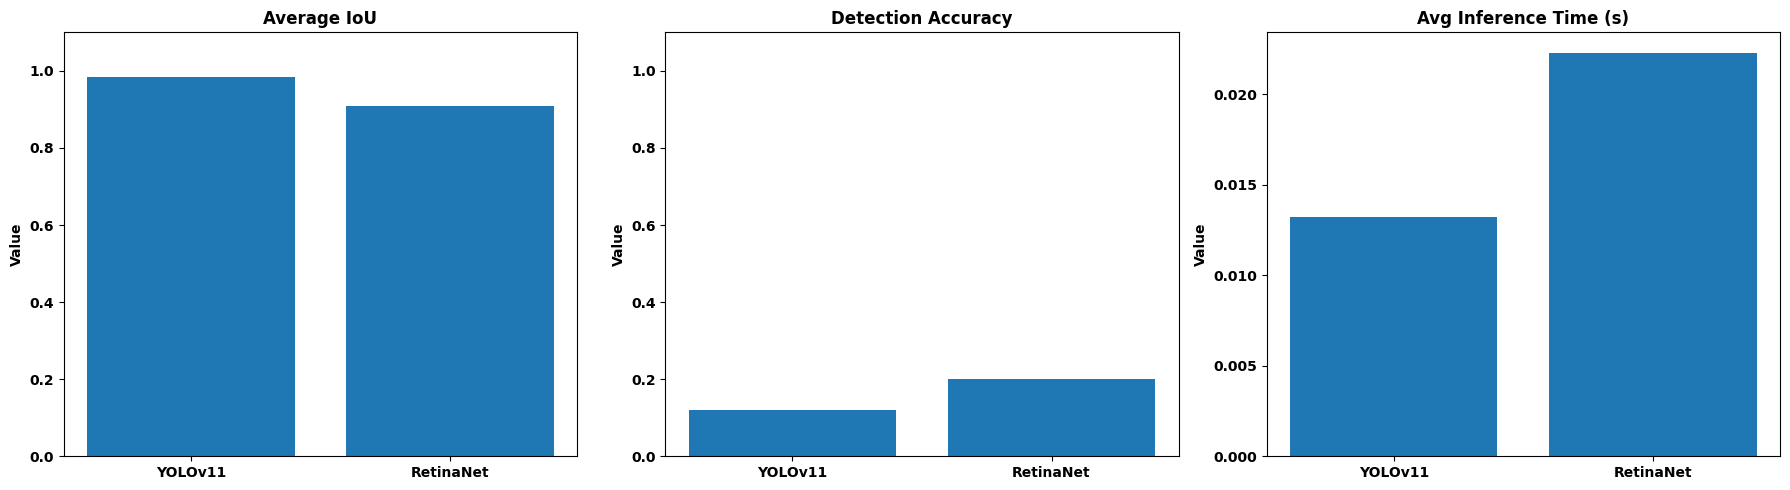

In [5]:
# %% [markdown]
# # 5. Evaluation Metrics Computation
def evaluate_detector_iou(detector_model, images, annotations, indices, iou_threshold=0.5):
    total_gt = 0
    matched_gt = 0
    for idx in indices:
        # Skip indices out of range
        if idx >= len(annotations):
            continue
        gt_boxes = extract_boxes(annotations[idx])
        if not gt_boxes:
            continue
        total_gt += len(gt_boxes)
        if detector_model == "yolo":
            pred_boxes = run_yolo_inference(model_yolo, images[idx])
        elif detector_model == "retina":
            pred_boxes = run_retina_inference(model_retina, images[idx])
        else:
            pred_boxes = []
        # Use the predicted box directly (no extra [0])
        for gt_box in gt_boxes:
            if any(compute_iou(gt_box, pb) >= iou_threshold for pb in pred_boxes):
                matched_gt += 1
    return matched_gt / total_gt if total_gt > 0 else 0.0
# We compute metrics such as IoU for each predicted box against the ground truth.
# Additional metrics like Precision, Recall, F1-Score, mAP, etc., are used to compare models.

# --------------------------

# Example: Compare the first ground truth box with YOLO and Retina detections.
gt_boxes = extract_boxes(annotations[0])
if gt_boxes:
    gt_box = gt_boxes[0]
    iou_yolo = compute_iou(gt_box, yolo_boxes[0]) if yolo_boxes else 0.0
    iou_retina = compute_iou(gt_box, retina_boxes[0]) if retina_boxes else 0.0
    print(f"IoU YOLOv11: {iou_yolo:.4f}")
    print(f"IoU RetinaNet: {iou_retina:.4f}")
else:
    print("DEBUG: No ground truth boxes available for the first image.")
    iou_yolo = 0.0
    iou_retina = 0.0


# --------------------------
# Compute real evaluation metrics on a random subset of the validation indices.
# Define validation indices based on the dataset size
val_indices = list(range(len(images)))

# Sample a subset of validation indices
num_val_samples = 10
sample_val_indices = random.sample(val_indices, min(num_val_samples, len(val_indices)))

iou_yolo_total = 0.0
iou_retina_total = 0.0
count_yolo = 0
count_retina = 0

for idx in sample_val_indices:
    gt_boxes = extract_boxes(annotations[idx])
    if not gt_boxes:
        continue
    gt_box = gt_boxes[0]  # only first GT box
    yolo_preds = run_yolo_inference(model_yolo, images[idx])
    retina_preds = run_retina_inference(model_retina, images[idx])
    if yolo_preds:
        iou_yolo_total += compute_iou(gt_box, yolo_preds[0])
        count_yolo += 1
    if retina_preds:
        iou_retina_total += compute_iou(gt_box, retina_preds[0])
        count_retina += 1

avg_iou_yolo = iou_yolo_total / count_yolo if count_yolo > 0 else 0.0
avg_iou_retina = iou_retina_total / count_retina if count_retina > 0 else 0.0


avg_iou_yolo = iou_yolo_total / count_yolo if count_yolo > 0 else 0.0
avg_iou_retina = iou_retina_total / count_retina if count_retina > 0 else 0.0

# Use your provided evaluation function for detection accuracy.
detector_acc_yolo = evaluate_detector_iou("yolo", images, annotations, sample_val_indices, iou_threshold=0.5)
detector_acc_retina = evaluate_detector_iou("retina", images, annotations, sample_val_indices, iou_threshold=0.5)

# Optionally, measure average inference time over these samples.

time_yolo = []
time_retina = []
for idx in sample_val_indices:
    start = time.time()
    _ = run_yolo_inference(model_yolo, images[idx])
    time_yolo.append(time.time() - start)
    start = time.time()
    _ = run_retina_inference(model_retina, images[idx])
    time_retina.append(time.time() - start)
avg_time_yolo = sum(time_yolo) / len(time_yolo) if time_yolo else 0.0
avg_time_retina = sum(time_retina) / len(time_retina) if time_retina else 0.0

# Build the metrics dataframe with real values.
metrics_df = pd.DataFrame({
    "Model": ["YOLOv11", "RetinaNet"],
    "Average IoU": [avg_iou_yolo, avg_iou_retina],
    "Detection Accuracy": [detector_acc_yolo, detector_acc_retina],
    "Avg Inference Time (s)": [avg_time_yolo, avg_time_retina]
})

# --------------------------
# Print the real evaluation metrics table.
try:
    print("\n📊 Real Evaluation Metrics Table:\n")
    print(metrics_df.to_markdown(index=False))
except ImportError:
    print("⚠ 'tabulate' is not installed. Showing plain table:")
    print(metrics_df)



# Extract valid metric values
models = metrics_df["Model"]
avg_iou = metrics_df["Average IoU"]
detection_accuracy = metrics_df["Detection Accuracy"]
inference_time = metrics_df["Avg Inference Time (s)"]

# Plot available metrics
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].bar(models, avg_iou)
axs[0].set_title("Average IoU")

axs[1].bar(models, detection_accuracy)
axs[1].set_title("Detection Accuracy")

axs[2].bar(models, inference_time)
axs[2].set_title("Avg Inference Time (s)")

for ax in axs:
    ax.set_ylabel("Value")
    if ax != axs[2]:  # don't limit inference time
        ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()



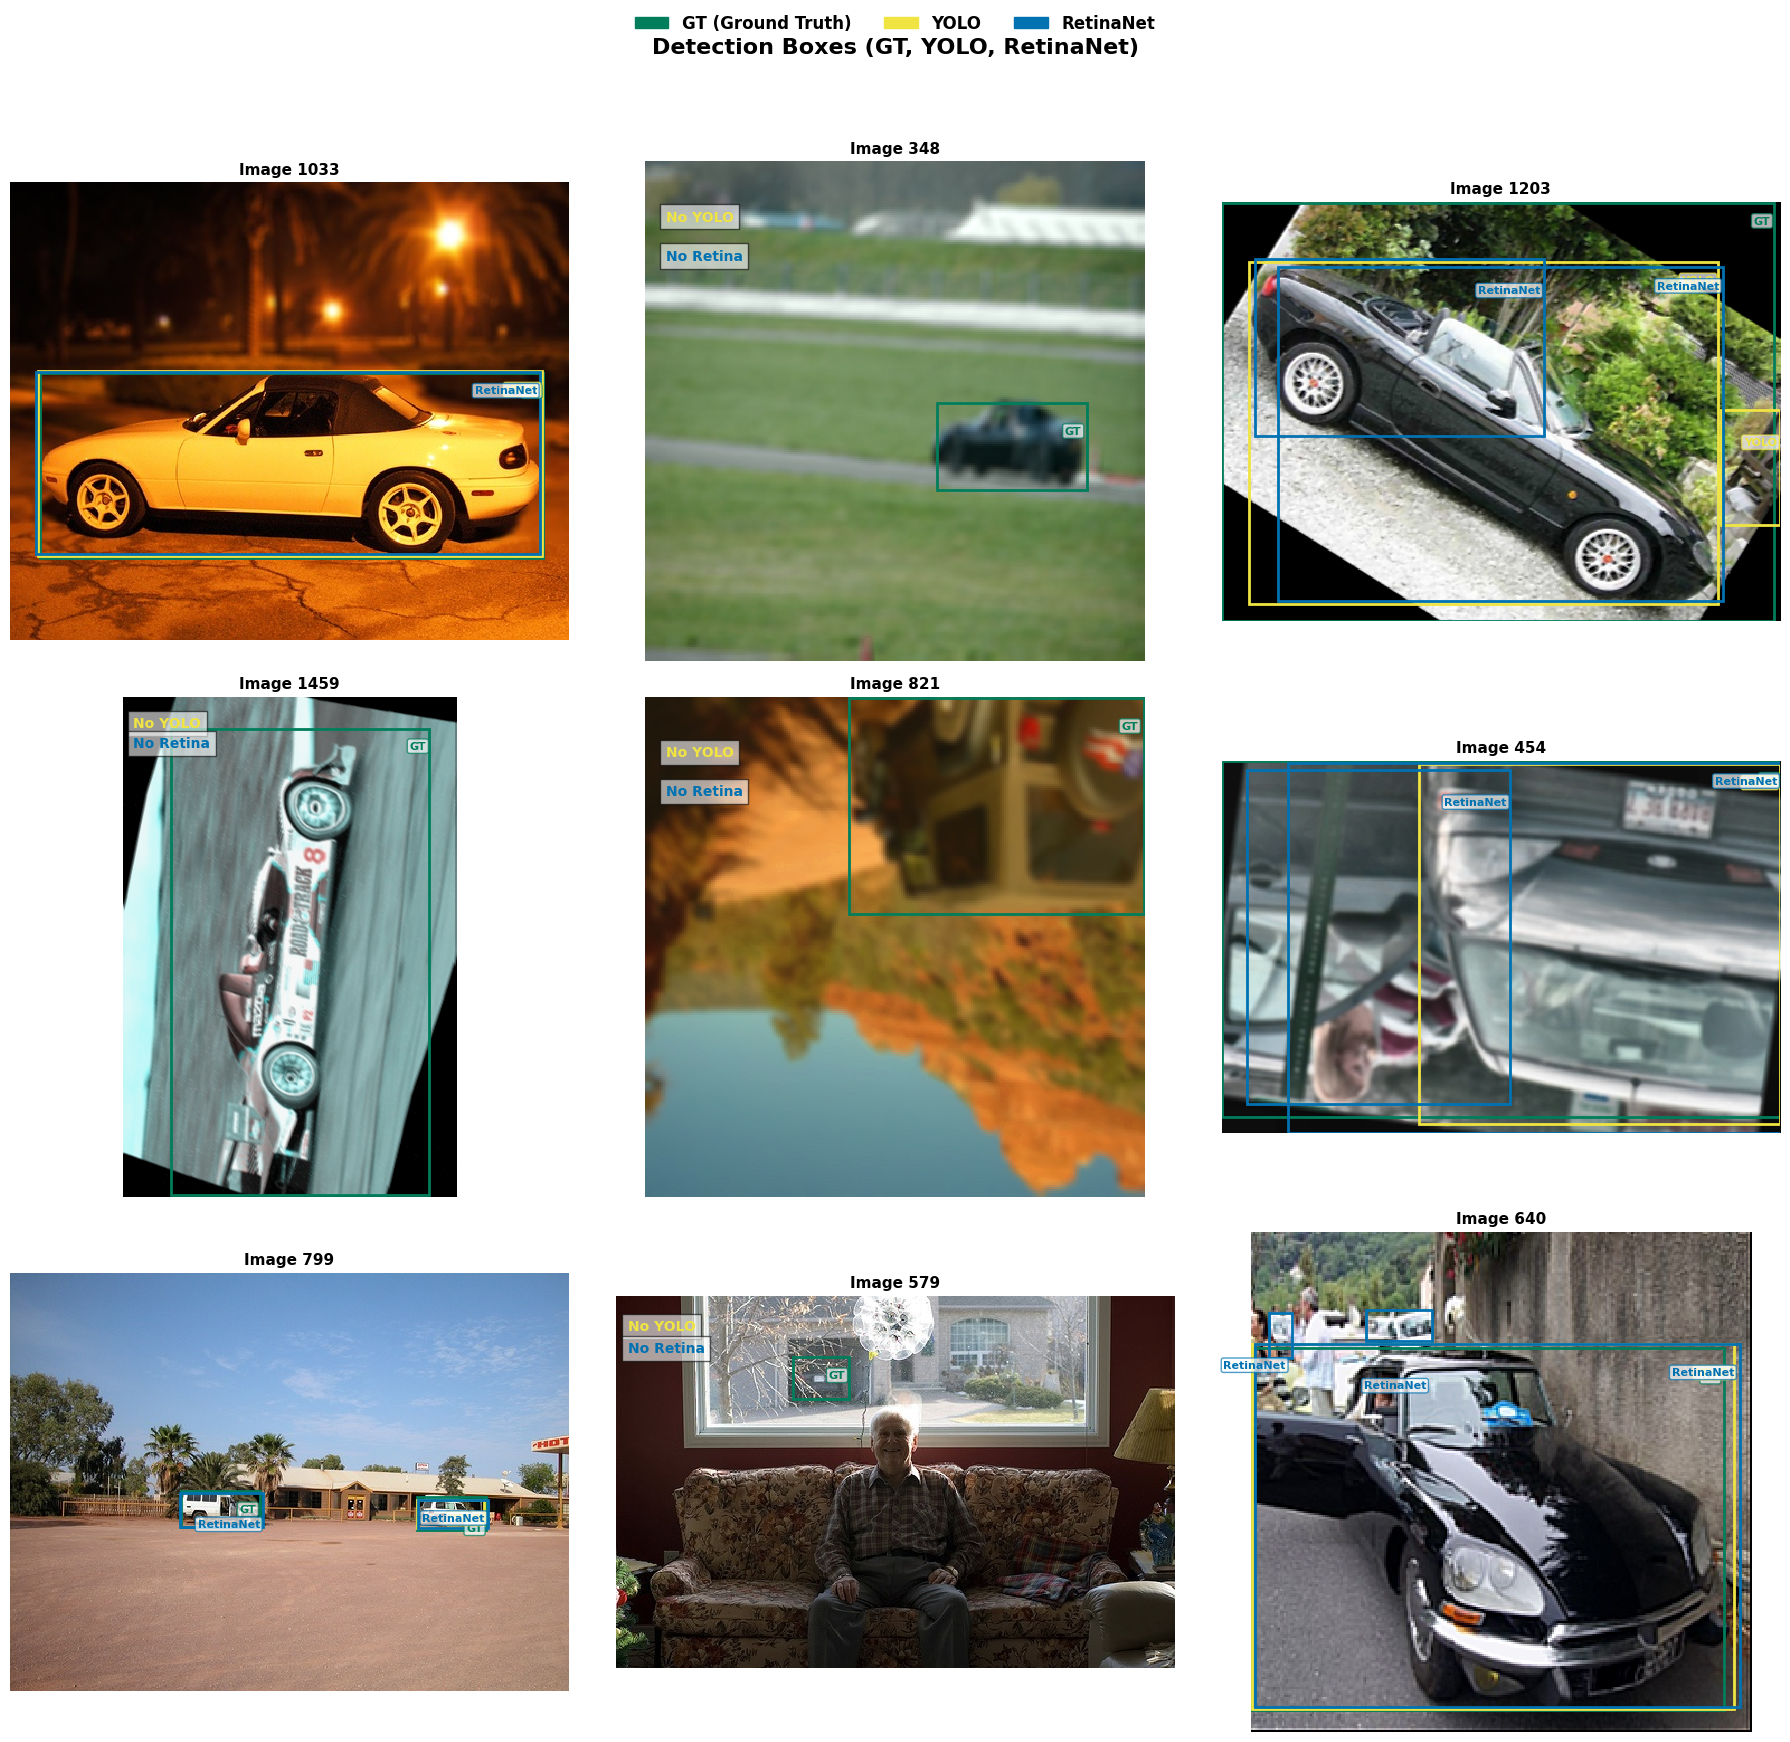


### 📊 Detection Summary Table:

|   Image |   GT Boxes |   YOLO Boxes |   Retina Boxes |
|---------|------------|--------------|----------------|
|    1033 |          1 |            1 |              1 |
|     348 |          1 |            0 |              0 |
|    1203 |          1 |            2 |              2 |
|    1459 |          1 |            0 |              0 |
|     821 |          1 |            0 |              0 |
|     454 |          1 |            1 |              2 |
|     799 |          2 |            1 |              2 |
|     579 |          1 |            0 |              0 |
|     640 |          1 |            1 |              3 |


In [6]:
# === Colorblind-Friendly Palette ===
colors = {
    'GT': '#007E5C',
    'YOLO': '#F0E442',
    'RetinaNet': '#0072B2'
}

# Number of test images to visualize (3x3)
num_test_images = 9
test_indices = random.sample(range(len(images)), num_test_images)

# Summary data
summary_data = []

# === Setup plot grid (3x3) ===
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
fig.suptitle("Detection Boxes (GT, YOLO, RetinaNet)", fontsize=16)
axes = axes.flatten()

# === Legend (clean and separate) ===
legend_patches = [
    patches.Patch(color=colors['GT'], label='GT (Ground Truth)'),
    patches.Patch(color=colors['YOLO'], label='YOLO'),
    patches.Patch(color=colors['RetinaNet'], label='RetinaNet')
]
fig.legend(handles=legend_patches, loc='upper center', ncol=3, fontsize=12, frameon=False)

# === Function to add boxes with clean label placement ===
def add_boxes(ax, boxes, color, label, position='right', y_offset=0):
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1

        # Draw the rectangle
        rect = patches.Rectangle(
            (x1, y1),
            w,
            h,
            linewidth=2,
            edgecolor=color,
            facecolor='none'
        )
        ax.add_patch(rect)

        # If you want the text “right-stuck” to the bounding box:
        lx = x2  # Right edge
        ly = y1  # Top edge
        ha = 'right'
        va = 'top'

        # Optional offset for each subsequent box
        offset = y_offset + (i * 12)

        # Place text slightly inside the box if you want it not to overflow:
        # e.g., lx - 3, ly + 12
        ax.text(
            lx - 3,              # small horizontal inset
            ly + 12 + offset,    # small vertical inset
            label,
            color=color,
            fontsize=8,
            ha=ha,
            va=va,
            bbox=dict(
                facecolor='white',
                edgecolor=color,
                alpha=0.7,
                boxstyle='round,pad=0.2'
            )
        )


# === Main visualization loop ===
for idx, ax in zip(test_indices, axes):
    image_np = images[idx]
    annotation = annotations[idx]

    yolo_boxes = run_yolo_inference(model_yolo, image_np)
    retina_boxes = run_retina_inference(model_retina, image_np)
    gt_boxes = extract_boxes(annotation)

    ax.imshow(image_np, interpolation='none')
    ax.set_title(f"Image {idx}", fontsize=11)

    # Boxes with spaced labels
    if gt_boxes:
        add_boxes(ax, gt_boxes, colors['GT'], 'GT', position='center')
    else:
        ax.text(10, 10, 'No GT', color=colors['GT'], fontsize=10,
                bbox=dict(facecolor='white', alpha=0.6))

    if yolo_boxes:
        add_boxes(ax, yolo_boxes, colors['YOLO'], 'YOLO', position='left')
    else:
        ax.text(10, 30, 'No YOLO', color=colors['YOLO'], fontsize=10,
                bbox=dict(facecolor='white', alpha=0.6))

    if retina_boxes:
        add_boxes(ax, retina_boxes, colors['RetinaNet'], 'RetinaNet', position='right')
    else:
        ax.text(10, 50, 'No Retina', color=colors['RetinaNet'], fontsize=10,
                bbox=dict(facecolor='white', alpha=0.6))
    summary_data.append({
        'Image': idx,
        'GT Boxes': len(gt_boxes),
        'YOLO Boxes': len(yolo_boxes),
        'Retina Boxes': len(retina_boxes),
        # Add anything else you want to track
    })

    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave space for legend and title
plt.show()

# === Summary Table ===
summary_df = pd.DataFrame(summary_data)
print("\n### 📊 Detection Summary Table:\n")
print(tabulate(summary_df, headers='keys', tablefmt='github', showindex=False))



✅ Found detections in image index: 1

===== Bounding Box Info =====
🔴 YOLO Box: [42.23480224609375, 70.49205017089844, 453.7259216308594, 271.49945068359375]
YOLO Class: person
🔵 RetinaNet Box: [12.28834342956543, 62.06342315673828, 492.2853698730469, 321.17364501953125]
RetinaNet Class: Not available
🟣 Union Box: [12.28834342956543, 62.06342315673828, 492.2853698730469, 321.17364501953125]
Crop Shapes:
  YOLO Crop: (201, 411, 3)
  Retina Crop: (259, 480, 3)
  Union Crop: (259, 480, 3)


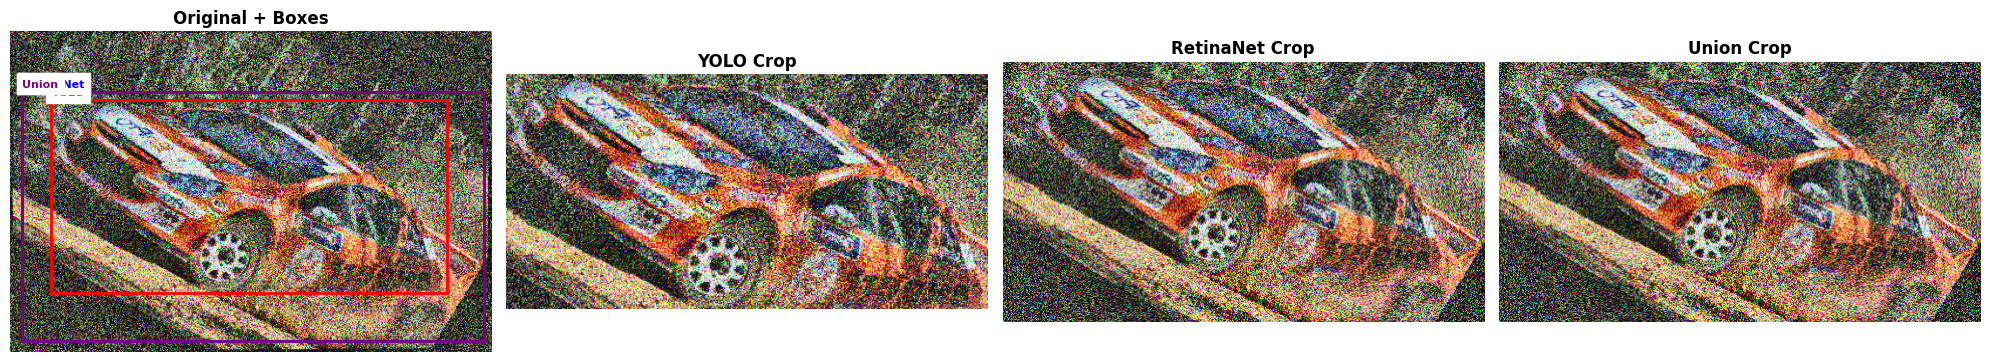

In [7]:
def crop_box(image, box):
    x1, y1, x2, y2 = map(int, box)
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    x2 = min(x2, image.shape[1])
    y2 = min(y2, image.shape[0])
    return image[y1:y2, x1:x2]

def visualize_and_crop(image_np, yolo_boxes, retina_boxes):
    if not yolo_boxes or not retina_boxes:
        print("❌ Missing boxes for this image.")
        return

    # Use first detected box from each
    yolo_box_coords = yolo_boxes[0]
    retina_box_coords = retina_boxes[0]

    print("\n===== Bounding Box Info =====")
    print(f"🔴 YOLO Box: {yolo_box_coords}")
    if hasattr(model_yolo, 'names'):
        print(f"YOLO Class: {model_yolo.names[0]}")  # Adjust if multiple classes

    print(f"🔵 RetinaNet Box: {retina_box_coords}")
    print("RetinaNet Class: Not available")

    # Compute union bounding box
    union_box = [
        min(yolo_box_coords[0], retina_box_coords[0]),
        min(yolo_box_coords[1], retina_box_coords[1]),
        max(yolo_box_coords[2], retina_box_coords[2]),
        max(yolo_box_coords[3], retina_box_coords[3])
    ]
    print(f"🟣 Union Box: {union_box}")

    # Crop regions
    crop_yolo = crop_box(image_np, yolo_box_coords)
    crop_retina = crop_box(image_np, retina_box_coords)
    crop_union = crop_box(image_np, union_box)

    print("Crop Shapes:")
    print(f"  YOLO Crop: {crop_yolo.shape}")
    print(f"  Retina Crop: {crop_retina.shape}")
    print(f"  Union Crop: {crop_union.shape}")

    # Visualization
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Original image with boxes
    axs[0].imshow(image_np)
    axs[0].set_title("Original + Boxes")

    def draw_box(ax, box, color, label):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, label, color=color, fontsize=8, backgroundcolor='white')

    draw_box(axs[0], yolo_box_coords, 'red', 'YOLO')
    draw_box(axs[0], retina_box_coords, 'blue', 'RetinaNet')
    draw_box(axs[0], union_box, 'purple', 'Union')

    # Show crops
    axs[1].imshow(crop_yolo)
    axs[1].set_title("YOLO Crop")

    axs[2].imshow(crop_retina)
    axs[2].set_title("RetinaNet Crop")

    axs[3].imshow(crop_union)
    axs[3].set_title("Union Crop")

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Try to find an image where both YOLO and RetinaNet return at least one box
for idx in range(len(images)):
    yolo_boxes = run_yolo_inference(model_yolo, images[idx])
    retina_boxes = run_retina_inference(model_retina, images[idx])

    if yolo_boxes and retina_boxes:
        print(f"✅ Found detections in image index: {idx}")
        visualize_and_crop(images[idx], yolo_boxes, retina_boxes)
        break
else:
    print("❌ No image found with both YOLO and RetinaNet detections.")



In [8]:
# %% [markdown]
# # 7. Graph Construction with TGraphX
#
# Each crop (detection box) becomes a node.
# We create edges based on the similarity (e.g., IoU) between the crops.
#
# Here we demonstrate how to create a graph per object instance using TGraphX’s API.
#
def build_detection_graph(crops, label, gt_box=None, union_box=None, device=torch.device("cpu"), sources=None):
    # Build node features using GPU-based individual resizing.
    node_features_list = []
    for crop in crops:
        crop_tensor = torch.from_numpy(crop).permute(2, 0, 1).unsqueeze(0).float().to(device) / 255.0
        resized = F.interpolate(crop_tensor, size=(32, 32), mode='bilinear', align_corners=False)
        node_features_list.append(resized.squeeze(0))
    node_features = torch.stack(node_features_list)

    # Set node source flags.
    if node_features.shape[0] == 3:
        node_sources = torch.tensor([0, 1, -1], dtype=torch.long, device=device)
    elif node_features.shape[0] == 2:
        detector_flag = 0
        if sources is not None and len(sources) > 0:
            detector_flag = 0 if sources[0] == "yolo" else 1
        node_sources = torch.tensor([detector_flag, -1], dtype=torch.long, device=device)
    else:
        node_sources = torch.full((node_features.shape[0],), -1, dtype=torch.long, device=device)

    # Build edge index.
    if node_features.shape[0] == 2:
        edge_index = torch.tensor([[0], [1]], dtype=torch.long, device=device)
    elif node_features.shape[0] == 3:
        edge_index = torch.tensor([[0, 1], [2, 2]], dtype=torch.long, device=device)
    else:
        edge_indices = []
        for i in range(node_features.shape[0]):
            for j in range(i+1, node_features.shape[0]):
                edge_indices.append([i, j])
                edge_indices.append([j, i])
        edge_index = (torch.tensor(edge_indices, dtype=torch.long, device=device).T
                      if edge_indices else torch.empty((2, 0), dtype=torch.long, device=device))

    # Build edge features.
    src_indices = edge_index[0]
    edge_features = node_sources[src_indices].float().unsqueeze(1)

    # Create the graph.
    graph = Graph(node_features, edge_index, edge_features=edge_features)

    # <<--- Add the detection boxes as attributes here --->
    if sources is not None:
        if "yolo" in sources:
            graph.yolo_box = best_yolo  # best_yolo must be provided in scope
        if "retina" in sources:
            graph.retina_box = best_retina  # best_retina must be provided in scope
        if "union" in sources:
            graph.union_box = union_box

    # Compute IoU based on graph attributes.
    if gt_box is not None:
        if label == 1 and hasattr(graph, "yolo_box"):
            computed_iou = compute_iou(gt_box, graph.yolo_box)
        elif label == 2 and hasattr(graph, "retina_box"):
            computed_iou = compute_iou(gt_box, graph.retina_box)
        elif label == 3 and hasattr(graph, "union_box"):
            computed_iou = compute_iou(gt_box, graph.union_box)
        else:
            computed_iou = 0.0
        graph.gt_iou = torch.tensor(computed_iou, device=device)
        graph.gt_box = gt_box
    else:
        graph.gt_iou = torch.tensor(0.0, device=device)

    # Attach the ground truth label to the graph.
    graph.label = torch.tensor(label, dtype=torch.long, device=device)

    return graph








# Here, we assume that the following functions are defined elsewhere:
# - run_yolo_inference(model, image_np)
# - run_retina_inference(model, image_np)
# - build_detection_graph(crops, label)
# - compute_iou(boxA, boxB)
# And that the variables 'images', 'annotations', 'model_yolo', and 'model_retina' are available.

# -------------------------------------------------------------------------------




torch.cuda.empty_cache()
gc.collect()

all_graphs = []
graph_image_ids = []
batch_size = 16  # Process 16 images simultaneously

# Free any leftover CPU and GPU memory from previous computations

gc.collect()
torch.cuda.empty_cache()

# Make sure RetinaNet is on GPU
model_retina = model_retina.to(device)

# Process images in batches with a tqdm progress bar
for batch_start in tqdm(range(0, len(images), batch_size), desc="Processing Images in Batches"):
    # Get indices and images for the current batch
    batch_indices = list(range(batch_start, min(batch_start + batch_size, len(images))))
    batch_images = [images[i] for i in batch_indices]

    # --- Run YOLO in batch ---
    yolo_batch_results = model_yolo(batch_images, augment=False, verbose=False)
    yolo_batch_detections = []
    for result in yolo_batch_results:
        boxes = []
        if hasattr(result, 'boxes'):
            for box in result.boxes:
                raw_class = int(box.cls.cpu().numpy()[0]) if hasattr(box, "cls") else None
                if raw_class == 2:  # Assuming class 2 corresponds to 'car'
                    xyxy = box.xyxy.cpu().numpy().tolist()[0]
                    boxes.append(xyxy)
        yolo_batch_detections.append(boxes)

    # --- Run RetinaNet in batch ---
    # Convert images to PIL and then to tensors on GPU
    pil_images = [Image.fromarray(img) if isinstance(img, np.ndarray) else img for img in batch_images]
    retina_tensors = [ToTensor()(img).to(device) for img in pil_images]
    with torch.no_grad():
        retina_outputs = model_retina(retina_tensors)
    retina_batch_detections = []
    for output in retina_outputs:
        boxes = []
        for score, box, raw_class in zip(output['scores'].detach().cpu().numpy(),
                                         output['boxes'].detach().cpu().numpy(),
                                         output['labels'].detach().cpu().numpy()):
            if score > 0.25 and raw_class == 3:  # Assuming class 3 corresponds to 'car'
                boxes.append(box.tolist())
        retina_batch_detections.append(boxes)

    # Process each image in the batch
    for local_idx, idx in enumerate(batch_indices):
        image_np = np.array(images[idx])
        gt_boxes = extract_boxes(annotations[idx])
        if not gt_boxes:
            continue

        yolo_detections = yolo_batch_detections[local_idx]
        retina_detections = retina_batch_detections[local_idx]

        for gt_box in gt_boxes:
            # Find best YOLO detection for this GT box
            best_yolo = None
            best_yolo_iou = 0.0
            for det in yolo_detections:
                iou = compute_iou(gt_box, det)
                if iou > best_yolo_iou:
                    best_yolo_iou = iou
                    best_yolo = det

            # Find best RetinaNet detection for this GT box
            best_retina = None
            best_retina_iou = 0.0
            for det in retina_detections:
                iou = compute_iou(gt_box, det)
                if iou > best_retina_iou:
                    best_retina_iou = iou
                    best_retina = det

            # Build the graph based on available detections.
            if best_yolo is not None and best_retina is not None:
                union_box = [
                    min(best_yolo[0], best_retina[0]),
                    min(best_yolo[1], best_retina[1]),
                    max(best_yolo[2], best_retina[2]),
                    max(best_yolo[3], best_retina[3])
                ]
                crop_yolo = crop_box(image_np, best_yolo)
                crop_retina = crop_box(image_np, best_retina)
                crop_union = crop_box(image_np, union_box)
                crops = [crop_yolo, crop_retina, crop_union]
                target_class = 1 if best_yolo_iou >= best_retina_iou else 2
                sources = ["yolo", "retina", "union"]
                graph = build_detection_graph(crops, label=target_class, gt_box=gt_box,
                                               union_box=union_box, device=device, sources=sources)
            elif best_yolo is not None or best_retina is not None:
                detector_name = "yolo" if best_yolo is not None else "retina"
                boxes = [best_yolo] if best_yolo is not None else [best_retina]
                crop = crop_box(image_np, boxes[0])
                crops = [crop, crop]
                target_class = 1 if detector_name == "yolo" else 2
                sources = [detector_name, "union"]
                union_box = boxes[0]
                graph = build_detection_graph(crops, label=target_class, gt_box=gt_box,
                                               union_box=union_box, device=device, sources=sources)
            else:
                # No detector fired for this GT box; build a default graph.
                h, w, _ = image_np.shape
                x1, y1 = w // 4, h // 4
                x2, y2 = (3 * w) // 4, (3 * h) // 4
                default_crop = image_np[y1:y2, x1:x2]
                crops = [default_crop, default_crop]
                target_class = 0
                sources = ["none", "none"]
                union_box = None
                graph = build_detection_graph(crops, label=target_class, gt_box=gt_box,
                                               union_box=union_box, device=device, sources=sources)

            graph.image_id = f"{idx}_{gt_box}"
            all_graphs.append(graph)
            graph_image_ids.append(f"{idx}_{gt_box}")

    # Free memory after processing each batch:
    del retina_outputs, retina_tensors, pil_images, batch_images
    gc.collect()
    torch.cuda.empty_cache()

print(f"Built graph dataset with {len(all_graphs)} samples.")
print("Count of 'not car' (0):", [g.label.item() for g in all_graphs].count(0))
print("Count of 'car' (1):", [g.label.item() for g in all_graphs].count(1))



Processing Images in Batches: 100%|██████████| 94/94 [01:29<00:00,  1.05it/s]

Built graph dataset with 3115 samples.
Count of 'not car' (0): 1245
Count of 'car' (1): 1019


In [9]:
# --- Graph Construction (Section 7) ---
# Assume you have already built graphs for all images and stored them in a list called `all_graphs`
# For example:
# all_graphs = [build_detection_graph(crops, label=1) for each image in your dataset]
graph_dataset = GraphDataset(all_graphs)
graph_loader = GraphDataLoader(graph_dataset, batch_size=1, shuffle=True)
if len(all_graphs) > 0:
    detection_graph = all_graphs[0]
    print("Graph constructed with node features shape:", detection_graph.node_features.shape)
    print("Edge index shape:", detection_graph.edge_index.shape if detection_graph.edge_index is not None else "None")
else:
    print("No graphs were built.")


# Check the distribution of labels in all_graphs
labels = [g.label.item() for g in all_graphs]
print("Count of 'not car' (0):", labels.count(0))
print("Count of 'car' (1):", labels.count(1))

Graph constructed with node features shape: torch.Size([2, 3, 32, 32])
Edge index shape: torch.Size([2, 1])
Count of 'not car' (0): 1245
Count of 'car' (1): 1019


In [10]:
# ------------------------------
# Helper function for safe conversion:
def safe_item(x):
    return x.item() if hasattr(x, "item") else x

# ------------------------------
# (Re)split the graph dataset into training and validation
all_indices = list(range(len(all_graphs)))
random.shuffle(all_indices)
val_ratio = 0.2
val_size = int(len(all_indices) * val_ratio)
val_indices = set(all_indices[:val_size])
train_indices = set(all_indices[val_size:])

train_graphs = [all_graphs[i] for i in train_indices]
val_graphs   = [all_graphs[i] for i in val_indices]

train_dataset = GraphDataset(train_graphs)
val_dataset   = GraphDataset(val_graphs)

train_loader = GraphDataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader   = GraphDataLoader(val_dataset, batch_size=1, shuffle=False)

print(f"Training samples:   {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# ------------------------------
# Model and Configuration
config = {
    "cnn_params": {
         "in_channels": 3,
         "out_features": 128,
         "num_layers": 8,
         "hidden_channels": 128,
         "dropout_prob": 0.2,
         "use_batchnorm": True,
         "use_residual": True,
         "pool_layers": 2,
         "debug": False,
         "return_feature_map": True
    },
    "gnn_in_dim": (128, 5, 5),
    "gnn_hidden_dim": (256, 5, 5),
    "num_classes": 4,  # 0: not car, 1: YOLO better, 2: Retina better, 3: Union better
    "num_gnn_layers": 3,
    "gnn_dropout": 0.2,
    "residual": True,
    "aggregator_params": {
         "num_layers": 2,
         "dropout_prob": 0.2,
         "use_batchnorm": True
    }
}

# Meta–aggregation function (for inference only):
def meta_tgraphx_aggregate(preds_list, meta_method="majority"):
    """
    Aggregates predictions from multiple detection graphs (from a single image).
    Here we use a majority vote.
    """
    vote = Counter(preds_list).most_common(1)[0][0]
    return vote

# A helper inference function for TGraphX output (used for debugging)
def tgraphx_inference(outputs):
    if isinstance(outputs, (tuple, list)) and len(outputs) >= 1:
        class_logits = outputs[0]
    else:
        class_logits = outputs
    pred_class = class_logits.argmax(dim=1).item()
    mapping = {0: "not car", 1: "Use YOLO", 2: "Use Retina", 3: "Use Union"}
    return mapping.get(pred_class, "unknown")




def compute_average_iou(detector_model, images, annotations, indices):
    total_iou = 0.0
    count = 0
    for idx in indices:
        gt_boxes = extract_boxes(annotations[idx])
        if not gt_boxes:
            continue
        if detector_model == "yolo":
            pred_boxes = run_yolo_inference(model_yolo, images[idx])
        elif detector_model == "retina":
            pred_boxes = run_retina_inference(model_retina, images[idx])
        else:
            pred_boxes = []
        # For each GT box, find the highest IoU among predicted boxes.
        for gt_box in gt_boxes:
            best_iou = 0.0
            for pb in pred_boxes:
                iou_val = compute_iou(gt_box, pb)  # Use pb directly, not pb[0]
                best_iou = max(best_iou, iou_val)
            total_iou += best_iou
            count += 1
    return total_iou / count if count > 0 else float('nan')




print("\n🔍 Device Info:")
if torch.cuda.is_available():
    print("✅ CUDA is available!")
    print(f"🖥️  GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("❌ CUDA not available. Using CPU.")

# Initialize the CNN-GNN model (TGraphX)
model_tgraphx = CNN_GNN_Model(
    cnn_params       = config["cnn_params"],
    gnn_in_dim       = config["gnn_in_dim"],
    gnn_hidden_dim   = config["gnn_hidden_dim"],
    num_classes      = config["num_classes"],
    num_gnn_layers   = config["num_gnn_layers"],
    gnn_dropout      = config["gnn_dropout"],
    residual         = config["residual"],
    aggregator_params= config["aggregator_params"],
    pre_encoder      = None
).to(device)

# Create optimizer and loss function
optimizer = optim.Adam(model_tgraphx.parameters(), lr=1e-3)
criterion_ce = torch.nn.CrossEntropyLoss()

# Add a learnable IoU head on top of the pooled features.
iou_head = torch.nn.Linear(config["gnn_hidden_dim"][0], 1).to(device)
optimizer.add_param_group({"params": iou_head.parameters()})

# A helper forward function that returns both logits and pooled features.
def forward_with_features(model, raw_node_data, edge_index, batch):
    # Run CNN encoder.
    cnn_out = model.encoder(raw_node_data)  # shape: [N, C, H, W]
    x = cnn_out
    for layer in model.gnn_layers:
        x = layer(x, edge_index)
        x = torch.relu(x)
    if x.dim() > 2:
        x = x.mean(dim=tuple(range(2, x.dim())))
    if batch is not None:
        num_graphs = batch.max().item() + 1
        pooled = torch.zeros(num_graphs, x.size(1), device=x.device)
        pooled = pooled.index_add(0, batch, x)
        counts = torch.zeros(num_graphs, device=x.device)
        ones = torch.ones(x.size(0), device=x.device)
        counts = counts.index_add(0, batch, ones).unsqueeze(1)
        pooled = pooled / counts.clamp(min=1)
    else:
        pooled = x
    logits = model.classifier(pooled)
    return logits, pooled

# Composite loss function combining CE loss and IoU loss.
alpha = 0.9
beta = 0.1
def composite_loss(outputs, target, gt_iou, alpha=alpha, beta=beta):
    if isinstance(outputs, (tuple, list)) and len(outputs) == 2:
        class_logits, iou_pred = outputs
    else:
        class_logits = outputs
        iou_pred = None
    ce_loss = criterion_ce(class_logits, target.unsqueeze(0))
    if target.item() != 0 and (iou_pred is not None):
        iou_loss = torch.mean((iou_pred - gt_iou) ** 2)
    else:
        iou_loss = torch.tensor(0.0, device=device)
    return alpha * ce_loss + beta * iou_loss, ce_loss, iou_loss

# --- Arrays to store metrics ---
train_history = []  # (epoch, train_loss, train_ce, train_iou, train_acc, avg_gt_iou, train_f1, train_bal_acc, epoch_time)
val_history = []    # (epoch, val_loss, val_ce, val_iou, val_acc, avg_gt_iou, val_f1, val_bal_acc)

# --- Evaluation Function for Per-Graph TGraphX ---
def evaluate_tgraphx(model, loader):
    model.eval()
    total_loss = total_ce = total_iou_loss = total_acc = total_gt_iou = 0.0
    valid_count = 0  # Initialize valid_count here
    num_batches = 0
    all_targets = []
    all_preds = []
    with torch.no_grad():
        for batch in loader:
            batch.node_features = batch.node_features.to(device)
            if batch.edge_index is not None:
                batch.edge_index = batch.edge_index.to(device)
            batch.batch = batch.batch.to(device)
            target = batch.graphs[0].label.to(device)
            gt_iou = batch.graphs[0].gt_iou if hasattr(batch.graphs[0], "gt_iou") else torch.tensor(0.0, device=device)
            logits, pooled = forward_with_features(model, batch.node_features, batch.edge_index, batch=batch.batch)
            iou_pred = iou_head(pooled).squeeze(1)
            outputs = (logits, iou_pred)
            comp_loss, ce_loss, iou_loss = composite_loss(outputs, target, gt_iou)
            total_loss += comp_loss.item()
            total_ce += ce_loss.item()
            total_iou_loss += iou_loss.item()
            class_logits = outputs if not (isinstance(outputs, (tuple, list)) and len(outputs)==2) else outputs[0]
            preds = class_logits.argmax(dim=1)
            acc = (preds == target).float().mean().item()
            # Only count accuracy for car samples (labels 1,2,3)
            if target.item() != 0:
                total_acc += acc
                valid_count += 1
            else:
                total_acc += 0  # Optionally, you can skip adding when target==0
            # Always accumulate gt_iou regardless of target
            total_gt_iou += gt_iou.item()
            #print(f"[DEBUG evaluate_tgraphx] Batch GT IoU: {gt_iou.item()}")
            all_targets.append(target.item())
            all_preds.append(preds.item())
            num_batches += 1
    avg_loss = total_loss / num_batches if num_batches else 0.0
    avg_ce = total_ce / num_batches if num_batches else 0.0
    avg_iou_loss = total_iou_loss / num_batches if num_batches else 0.0
    avg_acc = total_acc / valid_count if valid_count else 0.0
    avg_gt_iou = total_gt_iou / num_batches if num_batches else 0.0
    unique_labels = np.unique(all_targets)
    f1 = f1_score(all_targets, all_preds, labels=list(unique_labels), average="weighted", zero_division=1) if all_targets else 0.0
    bal_acc = balanced_accuracy_score(all_targets, all_preds) if all_targets else 0.0
    return avg_loss, avg_ce, avg_iou_loss, avg_acc, avg_gt_iou, f1, bal_acc

def evaluate_tgraphx_per_image(model, dataset):
    """
    Evaluates TGraphX accuracy per image.
    Assumes each graph in dataset has an attribute 'image_id'
    (with the image index as the first part, e.g. "12_gtBox")
    and that all graphs for the same image share the same ground truth label.
    """
    model.eval()
    image_predictions = defaultdict(list)
    image_ground_truth = {}

    with torch.no_grad():
        # Group predictions by image
        for graph in dataset.graphs:  # assuming dataset.graphs is a list of graphs
            image_idx = graph.image_id.split("_")[0]
            # Move features to device
            graph.node_features = graph.node_features.to(device)
            if graph.edge_index is not None:
                graph.edge_index = graph.edge_index.to(device)
            # Use a dummy batch vector for a single graph
            batch_tensor = torch.zeros(graph.node_features.shape[0], dtype=torch.long, device=device)
            logits, _ = forward_with_features(model, graph.node_features, graph.edge_index, batch_tensor)
            pred = logits.argmax(dim=1).item()
            image_predictions[image_idx].append(pred)
            # Record ground truth (all graphs in one image should share it)
            if image_idx not in image_ground_truth:
                image_ground_truth[image_idx] = graph.label.item()

    # Aggregate predictions per image using your meta-aggregation function
    correct = 0
    total = 0
    for img_idx, preds in image_predictions.items():
        final_pred = meta_tgraphx_aggregate(preds)
        gt = image_ground_truth[img_idx]
        if final_pred == gt:
            correct += 1
        total += 1
    return correct / total if total > 0 else 0.0


# Group graphs by the image part of their image_id (assumes format "idx_gtBox")
train_groups = defaultdict(list)
for g in train_graphs:
    image_idx = g.image_id.split("_")[0]
    train_groups[image_idx].append(g)
train_image_batches = list(train_groups.values())


# (For validation you can do a similar grouping if desired;
# here we will continue to use the per–graph loader for validation.)

# ======================================================
# Revised Training Loop: Aggregating losses per full image
# ======================================================
best_val_score = float('inf')
best_epoch = -1
train_history = []
val_history = []
num_epochs = 50

print("\n--- Starting Training (Per–Image Loss Aggregation) ---")
for epoch in range(1, num_epochs+1):
    model_tgraphx.train()
    epoch_loss_total = 0.0
    epoch_ce_total = 0.0
    epoch_iou_total = 0.0
    epoch_acc_total = 0.0
    epoch_gt_iou_total = 0.0
    n_image_batches = 0
    all_train_targets = []
    all_train_preds = []

    start_time = time.time()
    debug_printed = True #True means dont print

    # Loop over images (each image may have one or more detection graphs)
    for group in train_image_batches:
        group_loss = 0.0
        group_ce = 0.0
        group_iou = 0.0
        group_acc = 0.0
        group_gt_iou = 0.0
        count = 0

        # Process each detection graph from the same image
        for graph in group:
            # (Treat each graph as a mini–batch of one.)
            graph.node_features = graph.node_features.to(device)
            if graph.edge_index is not None:
                graph.edge_index = graph.edge_index.to(device)
            # We use a dummy batch vector of zeros (since each graph is independent)
            batch_tensor = torch.zeros(graph.node_features.shape[0], dtype=torch.long, device=device)
            target = graph.label.to(device)
            gt_iou = graph.gt_iou if hasattr(graph, "gt_iou") else torch.tensor(0.0, device=device)

            optimizer.zero_grad()
            logits, pooled = forward_with_features(model_tgraphx, graph.node_features, graph.edge_index, batch=batch_tensor)
            iou_pred = iou_head(pooled).squeeze(1)
            outputs = (logits, iou_pred)
            loss, ce_loss, iou_loss = composite_loss(outputs, target, gt_iou)
            loss.backward()
            optimizer.step()

            # Compute classification accuracy on this graph
            class_logits = logits  # we use the classification output only
            pred = class_logits.argmax(dim=1)
            acc = (pred == target.unsqueeze(0)).float().mean().item()

            group_loss += loss.item()
            group_ce += ce_loss.item()
            group_iou += iou_loss.item()
            group_acc += acc
            # Retrieve the boxes from the graph
            # Retrieve boxes from the graph
            gt_box = getattr(graph, "gt_box", None)
            yolo_box = getattr(graph, "yolo_box", None)
            retina_box = getattr(graph, "retina_box", None)
            union_box = getattr(graph, "union_box", None)

            if isinstance(gt_box, (list, tuple)):
                if target.item() == 1 and isinstance(yolo_box, (list, tuple)):
                    computed_iou = compute_iou(gt_box, yolo_box)
                elif target.item() == 2 and isinstance(retina_box, (list, tuple)):
                    computed_iou = compute_iou(gt_box, retina_box)
                elif target.item() == 3 and isinstance(union_box, (list, tuple)):
                    computed_iou = compute_iou(gt_box, union_box)
                else:
                    computed_iou = 0.0
            else:
                computed_iou = 0.0
            # Store the computed IoU in the graph (so evaluation can use it)
            graph.gt_iou = torch.tensor(computed_iou, device=device)
            # Also add to a local accumulator for per-image averages:
            group_gt_iou += computed_iou







            all_train_targets.append(target.item())
            all_train_preds.append(pred.item())
            count += 1

            # Debug print from one graph in the group (only once per image)
            if epoch % 5 == 0 and not debug_printed:
                debug_printed = True
                # Here we use global yolo_boxes and retina_boxes for reference if available.
                yolo_box = yolo_boxes[0] if 'yolo_boxes' in globals() and yolo_boxes else "N/A"
                retina_box = retina_boxes[0] if 'retina_boxes' in globals() and retina_boxes else "N/A"
                gt_box = getattr(graph, "gt_box", "N/A")
                try:
                    yolo_iou_val = compute_iou(gt_box, yolo_box) if (isinstance(gt_box, (list, tuple)) and isinstance(yolo_box, (list, tuple))) else 0.0
                    retina_iou_val = compute_iou(gt_box, retina_box) if (isinstance(gt_box, (list, tuple)) and isinstance(retina_box, (list, tuple))) else 0.0
                except Exception as e:
                    yolo_iou_val = retina_iou_val = 0.0
                class_mapping = {0: "not car", 1: "YOLO better", 2: "Retina better", 3: "Union better"}
                pred_class = class_logits.argmax(dim=1).item()
                print("[DEBUG] (Per Image) Sample Graph in this Image:")
                print(f"  - YOLO Box: {yolo_box}")
                print(f"  - Retina Box: {retina_box}")
                print(f"  - GT Box: {gt_box}")
                print(f"  - Graph Sources: {graph.sources}")
                print(f"  - TGraphX Predicted Class: {pred_class} ({class_mapping.get(pred_class, 'unknown')})")
                print(f"  - Ground Truth Label: {target.item()}")
                print(f"  - GT IoU (from graph): {safe_item(gt_iou):.4f}")
                print(f"  - YOLO IoU: {yolo_iou_val:.4f}")
                print(f"  - Retina IoU: {retina_iou_val:.4f}")
                print(f"  - CE Loss: {safe_item(ce_loss):.4f}")
                print(f"  - IoU Loss: {safe_item(iou_loss):.4f}")
                print(f"  - Composite Loss: {safe_item(loss):.4f}")

        # Average over all graphs in this image
        if count > 0:
            image_loss_avg = group_loss / count
            image_ce_avg = group_ce / count
            image_iou_avg = group_iou / count
            image_acc_avg = group_acc / count
            image_gt_iou_avg = group_gt_iou / count

            epoch_loss_total += image_loss_avg
            epoch_ce_total += image_ce_avg
            epoch_iou_total += image_iou_avg
            epoch_acc_total += image_acc_avg
            epoch_gt_iou_total += image_gt_iou_avg
            n_image_batches += 1

    # Compute overall averages per full image.
    avg_train_loss = epoch_loss_total / n_image_batches if n_image_batches else 0.0
    avg_train_ce = epoch_ce_total / n_image_batches if n_image_batches else 0.0
    avg_train_iou_loss = epoch_iou_total / n_image_batches if n_image_batches else 0.0
    avg_train_acc = epoch_acc_total / n_image_batches if n_image_batches else 0.0
    avg_train_gt_iou = epoch_gt_iou_total / n_image_batches if n_image_batches else 0.0
    train_f1 = f1_score(all_train_targets, all_train_preds, average="weighted") if all_train_targets else 0.0
    train_bal_acc = balanced_accuracy_score(all_train_targets, all_train_preds) if all_train_targets else 0.0
    epoch_time = time.time() - start_time
    train_history.append((epoch, avg_train_loss, avg_train_ce, avg_train_iou_loss, avg_train_acc,
                        avg_train_gt_iou, train_f1, train_bal_acc, epoch_time))


    # For validation we continue to use our per-graph evaluation (for brevity)
    val_loss, val_ce, val_iou_loss, val_acc, val_gt_iou, val_f1, val_bal_acc = evaluate_tgraphx(model_tgraphx, val_loader)
    val_history.append((epoch, val_loss, val_ce, val_iou_loss, val_acc, val_gt_iou, val_f1, val_bal_acc))

    # Compute a combined validation score (lower is better)
    val_combined_score = math.sqrt((1 - val_acc)**2 + val_loss**2)
    if epoch == 1 or val_combined_score < best_val_score:
        best_val_score = val_combined_score
        best_epoch = epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_tgraphx.state_dict(),
            'iou_head_state_dict': iou_head.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc
        }, "best_tgraphx_model.pt")
        print(f"💾 Saved new best model at epoch {epoch} (Val Score = {val_combined_score:.4f})")

    print(f"[Epoch {epoch:02d}] Train Loss: {avg_train_loss:.4f} (CE: {avg_train_ce:.4f}, IoU Loss: {avg_train_iou_loss:.4f}) | "
      f"Train Acc: {avg_train_acc:.4f} | Val Loss: {val_loss:.4f} (CE: {val_ce:.4f}, IoU Loss: {val_iou_loss:.4f}) | "
      f"Val Acc: {val_acc:.4f} | Avg GT IoU: {val_gt_iou:.4f} | F1: {val_f1:.4f} | Bal Acc: {val_bal_acc:.4f} | "
      f"Epoch Time: {epoch_time:.2f}s")


# ==============================================================================
# Scientific Explanation Before Final Table:
print("\n=== Scientific Explanation ===")
print("• The training losses (composite, CE, and IoU) are now aggregated per full image:")
print("   For each full image, we average the losses over all detection graphs generated from that image.")
print("• 'Train Acc' is the average classification accuracy per full image.")
print("• 'Avg GT IoU (Car Samples)' is computed only for graphs labeled as 'car' (numeric label 1) and represents")
print("   the average Intersection-over-Union between the ground truth box and the union crop. A constant value")
print("   might indicate that the union crop is being set equal to the ground truth box (or that the detection")
print("   procedure is consistent), but if unexpected, this should be investigated.")
print("• The validation metrics are still computed per detection graph (for brevity), but ideally you could also")
print("   group validation graphs by image and compute per-image averages.")
print("• Misclassification is penalized in the CE loss, and if an object is detected where it should not be (or vice versa)")
print("   the loss reflects this through a higher CE value. Similarly, if the union crop does not align well with the")
print("   ground truth box, the IoU loss will be high.")
print("================================\n")

# ==============================================================================
# Final Comparison Table:
final_tgraphx_class_acc = evaluate_tgraphx_per_image(model_tgraphx, val_dataset) # avg_acc is at index 3 from TGraphX evaluation
final_tgraphx_gt_iou = val_history[-1][4]      # avg_gt_iou is at index 4 from TGraphX evaluation

all_image_indices = list(range(len(images)))
final_yolo_iou = compute_average_iou("yolo", images, annotations, all_image_indices)
final_retina_iou = compute_average_iou("retina", images, annotations, all_image_indices)

final_comparison_df = pd.DataFrame({
    "Model": ["YOLOv11", "RetinaNet", "TGraphX"],
    "Val Accuracy (Classification)": [
        evaluate_detector_iou("yolo", images, annotations, all_image_indices, 0.5),
        evaluate_detector_iou("retina", images, annotations, all_image_indices, 0.5),
        final_tgraphx_class_acc
    ],
    "Val Avg IoU": [
        final_yolo_iou,
        final_retina_iou,
        final_tgraphx_gt_iou
    ]
})




print("Final Model Comparison on Validation Set (Real Data):")
print(final_comparison_df.to_markdown(index=False))

# ==============================================================================
# Detailed Training & Validation Metrics Table:
detailed_metrics = {
    "Epoch": ["Aggregated (per full image)"],
    "Train Loss (Composite)": [avg_train_loss],
    "Train CE Loss": [avg_train_ce],
    "Train IoU Loss": [avg_train_iou_loss],
    "Train Acc": [avg_train_acc],
    "Val Loss (Composite)": [val_loss],
    "Val CE Loss": [val_ce],
    "Val IoU Loss": [val_iou_loss],
    "Val Acc": [val_acc],
    "Avg GT IoU (Car Samples)": [val_gt_iou],
    "Val F1": [val_f1],
    "Val Balanced Acc": [val_bal_acc]
}

detailed_df = pd.DataFrame(detailed_metrics)
print("\nDetailed Training & Validation Metrics (Aggregated per Full Image):")
print(detailed_df.to_markdown(index=False))

print("\nDetailed Training & Validation Metrics (Aggregated per Full Image):")
print(detailed_df.to_markdown(index=False))

Training samples:   2492
Validation samples: 623

🔍 Device Info:
✅ CUDA is available!
🖥️  GPU Name: NVIDIA GeForce RTX 5080

--- Starting Training (Per–Image Loss Aggregation) ---
💾 Saved new best model at epoch 1 (Val Score = 1.7997)
[Epoch 01] Train Loss: 0.8546 (CE: 0.9435, IoU Loss: 0.0553) | Train Acc: 0.5343 | Val Loss: 1.7433 (CE: 1.5243, IoU Loss: 3.7142) | Val Acc: 0.5531 | Avg GT IoU: 0.4343 | F1: 0.1533 | Bal Acc: 0.3333 | Epoch Time: 26.80s
💾 Saved new best model at epoch 2 (Val Score = 1.3999)
[Epoch 02] Train Loss: 0.7040 (CE: 0.7771, IoU Loss: 0.0456) | Train Acc: 0.6561 | Val Loss: 1.3266 (CE: 1.2034, IoU Loss: 2.4357) | Val Acc: 0.5531 | Avg GT IoU: 0.4343 | F1: 0.1533 | Bal Acc: 0.3333 | Epoch Time: 26.91s
💾 Saved new best model at epoch 3 (Val Score = 0.9668)
[Epoch 03] Train Loss: 0.7017 (CE: 0.7748, IoU Loss: 0.0438) | Train Acc: 0.6515 | Val Loss: 0.8498 (CE: 0.8236, IoU Loss: 1.0855) | Val Acc: 0.5391 | Avg GT IoU: 0.4343 | F1: 0.6116 | Bal Acc: 0.6195 | Epoch Ti

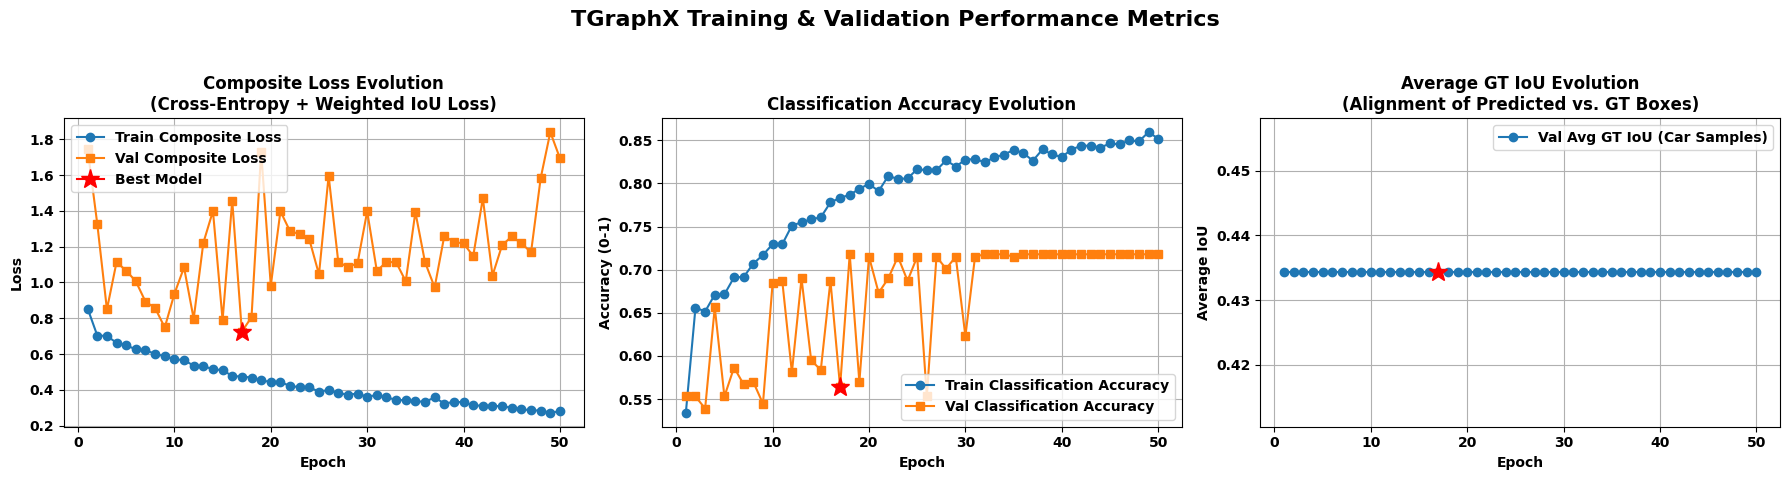

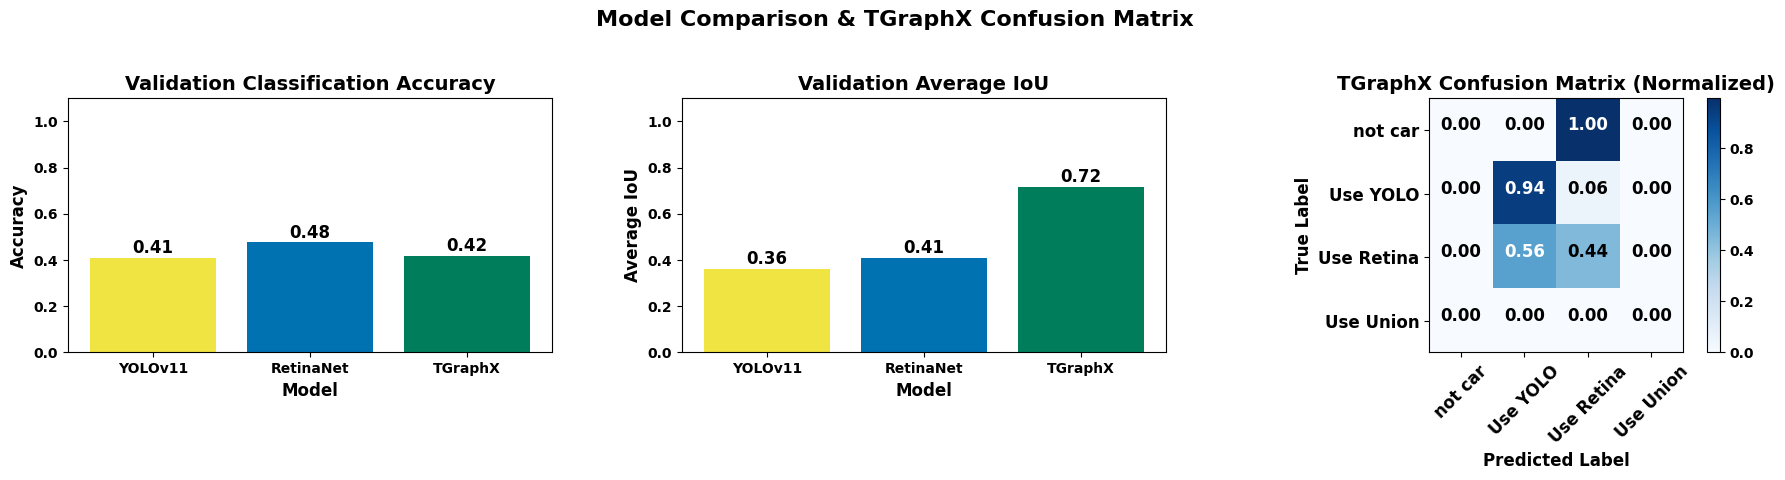

In [11]:
# ========================
# Figure 1: Training Curves
# ========================
# Assumed train_history: (epoch, train_loss, train_ce, train_iou_loss, train_acc, train_gt_iou, train_f1, train_bal_acc, epoch_time)
epochs_list   = [ep for (ep, _, _, _, _, _, _, _, _) in train_history]
train_losses  = [t_loss for (_, t_loss, _, _, _, _, _, _, _) in train_history]
train_accs    = [t_acc for (_, _, _, _, t_acc, _, _, _, _) in train_history]

# Assumed val_history: (epoch, val_loss, val_ce, val_iou_loss, val_acc, val_gt_iou, val_f1, val_bal_acc)
val_losses    = [v_loss for (_, v_loss, _, _, _, _, _, _) in val_history]
val_accs      = [v_acc for (_, _, _, _, v_acc, _, _, _) in val_history]
val_gt_ious   = [v_gt for (_, _, _, _, _, v_gt, _, _) in val_history]

# Best epoch (1-indexed) from training
best_epoch_idx = best_epoch - 1
best_epoch_val = epochs_list[best_epoch_idx]

plt.figure(figsize=(18, 5))

# Subplot 1: Composite Loss Evolution
plt.subplot(1, 3, 1)
plt.plot(epochs_list, train_losses, label="Train Composite Loss", marker='o')
plt.plot(epochs_list, val_losses, label="Val Composite Loss", marker='s')
plt.plot(best_epoch_val, val_losses[best_epoch_idx], marker='*', color='red', markersize=14, label='Best Model')
plt.title("Composite Loss Evolution\n(Cross-Entropy + Weighted IoU Loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Subplot 2: Classification Accuracy Evolution
plt.subplot(1, 3, 2)
plt.plot(epochs_list, train_accs, label="Train Classification Accuracy", marker='o')
plt.plot(epochs_list, val_accs, label="Val Classification Accuracy", marker='s')
plt.plot(best_epoch_val, val_accs[best_epoch_idx], marker='*', color='red', markersize=14)
plt.title("Classification Accuracy Evolution")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (0-1)")
plt.legend()
plt.grid(True)

# Subplot 3: Average GT IoU Evolution
plt.subplot(1, 3, 3)
plt.plot(epochs_list, val_gt_ious, label="Val Avg GT IoU (Car Samples)", marker='o')
plt.plot(best_epoch_val, val_gt_ious[best_epoch_idx], marker='*', color='red', markersize=14)
plt.title("Average GT IoU Evolution\n(Alignment of Predicted vs. GT Boxes)")
plt.xlabel("Epoch")
plt.ylabel("Average IoU")
plt.legend()
plt.grid(True)

plt.suptitle("TGraphX Training & Validation Performance Metrics", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ===========================
# Figure 2: Model Comparison & TGraphX Confusion Matrix
# ===========================
# final_comparison_df is assumed to be defined with columns:
# "Model", "Val Accuracy (Classification)", "Val Avg IoU"
models = final_comparison_df["Model"]
accuracies = final_comparison_df["Val Accuracy (Classification)"]
avg_ious   = final_comparison_df["Val Avg IoU"]

# Also, compute TGraphX confusion matrix on the validation set.
# We iterate over the val_loader to collect predictions.
all_val_targets = []
all_val_preds = []
model_tgraphx.eval()
with torch.no_grad():
    for batch in val_loader:
        batch.node_features = batch.node_features.to(device)
        if batch.edge_index is not None:
            batch.edge_index = batch.edge_index.to(device)
        batch.batch = batch.batch.to(device)
        target = batch.graphs[0].label.to(device)
        logits, _ = forward_with_features(model_tgraphx, batch.node_features, batch.edge_index, batch=batch.batch)
        pred = logits.argmax(dim=1).item()
        all_val_targets.append(target.item())
        all_val_preds.append(pred)

# Compute confusion matrix for classes 0,1,2,3.
cm = confusion_matrix(all_val_targets, all_val_preds, labels=[0, 1, 2, 3])
row_sums = cm.sum(axis=1)
# Replace any 0 row sum with 1 to avoid division by zero
row_sums = np.where(row_sums == 0, 1, row_sums)
cm_norm = cm.astype('float') / row_sums[:, np.newaxis]


# Define a function to plot confusion matrix (using matplotlib)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

# Create Figure 2 with three subplots.
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Subplot 1: Validation Classification Accuracy Comparison
axs[0].bar(models, accuracies, color=['#F0E442','#0072B2','#007E5C'])
axs[0].set_title("Validation Classification Accuracy", fontsize=14)
axs[0].set_xlabel("Model", fontsize=12)
axs[0].set_ylabel("Accuracy", fontsize=12)
axs[0].set_ylim(0, 1.1)
for i, v in enumerate(accuracies):
    axs[0].text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold', fontsize=12)

# Subplot 2: Validation Average IoU Comparison
axs[1].bar(models, avg_ious, color=['#F0E442','#0072B2','#007E5C'])
axs[1].set_title("Validation Average IoU", fontsize=14)
axs[1].set_xlabel("Model", fontsize=12)
axs[1].set_ylabel("Average IoU", fontsize=12)
axs[1].set_ylim(0, 1.1)
for i, v in enumerate(avg_ious):
    axs[1].text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold', fontsize=12)

# Subplot 3: Confusion Matrix for TGraphX (classes: 0,1,2,3)
classes = ["not car", "Use YOLO", "Use Retina", "Use Union"]
plt.sca(axs[2])
plot_confusion_matrix(cm_norm, classes, normalize=True,
                      title="TGraphX Confusion Matrix (Normalized)")

fig.suptitle("Model Comparison & TGraphX Confusion Matrix", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
